In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [36]:
data_dir = "simulator-windows-64\\Data\\IMG"
cols = ['centre', 'left','right','steering','throttle','reverse','speed']
data = pd.read_csv('simulator-windows-64\\Data\\driving_log.csv', names = cols)
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,C:\Users\HP\Self-Driving Car\simulator-windows...,C:\Users\HP\Self-Driving Car\simulator-window...,C:\Users\HP\Self-Driving Car\simulator-window...,0.0,0.0,0,0.000078
1,C:\Users\HP\Self-Driving Car\simulator-windows...,C:\Users\HP\Self-Driving Car\simulator-window...,C:\Users\HP\Self-Driving Car\simulator-window...,0.0,0.0,0,0.000078
2,C:\Users\HP\Self-Driving Car\simulator-windows...,C:\Users\HP\Self-Driving Car\simulator-window...,C:\Users\HP\Self-Driving Car\simulator-window...,0.0,0.0,0,0.000078
3,C:\Users\HP\Self-Driving Car\simulator-windows...,C:\Users\HP\Self-Driving Car\simulator-window...,C:\Users\HP\Self-Driving Car\simulator-window...,0.0,0.0,0,0.000079
4,C:\Users\HP\Self-Driving Car\simulator-windows...,C:\Users\HP\Self-Driving Car\simulator-window...,C:\Users\HP\Self-Driving Car\simulator-window...,0.0,0.0,0,0.000080


In [37]:
import ntpath 
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['centre'] = data['centre'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,center_2024_03_19_14_54_44_226.jpg,left_2024_03_19_14_54_44_226.jpg,right_2024_03_19_14_54_44_226.jpg,0.0,0.0,0,0.000078
1,center_2024_03_19_14_54_44_329.jpg,left_2024_03_19_14_54_44_329.jpg,right_2024_03_19_14_54_44_329.jpg,0.0,0.0,0,0.000078
2,center_2024_03_19_14_54_44_437.jpg,left_2024_03_19_14_54_44_437.jpg,right_2024_03_19_14_54_44_437.jpg,0.0,0.0,0,0.000078
3,center_2024_03_19_14_54_44_539.jpg,left_2024_03_19_14_54_44_539.jpg,right_2024_03_19_14_54_44_539.jpg,0.0,0.0,0,0.000079
4,center_2024_03_19_14_54_44_646.jpg,left_2024_03_19_14_54_44_646.jpg,right_2024_03_19_14_54_44_646.jpg,0.0,0.0,0,0.000080


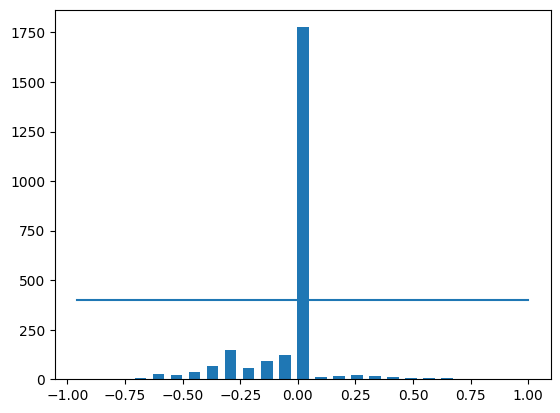

In [38]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [40]:
import random
from sklearn.utils import shuffle

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 1376
remaining: 1079


In [41]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [42]:
import os
image_paths, steerings = load_img_steering('simulator-windows-64\\Data\\IMG', data)

In [43]:
len(image_paths)

3237

In [44]:
len(steerings)

3237

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 2589
Valid Samples: 648


Text(0.5, 1.0, 'Validation set')

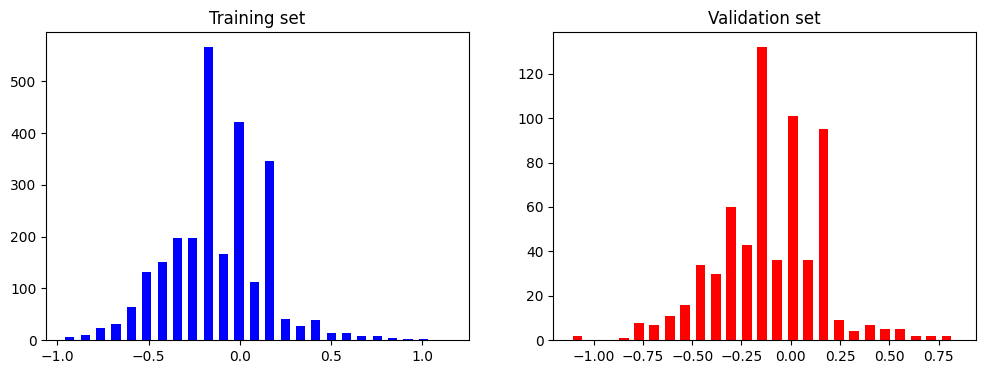

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [49]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [50]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [51]:
import cv2
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

NameError: name 'cv2' is not defined

In [52]:
def batch_generator(image_paths, steering_ang, batch_size):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

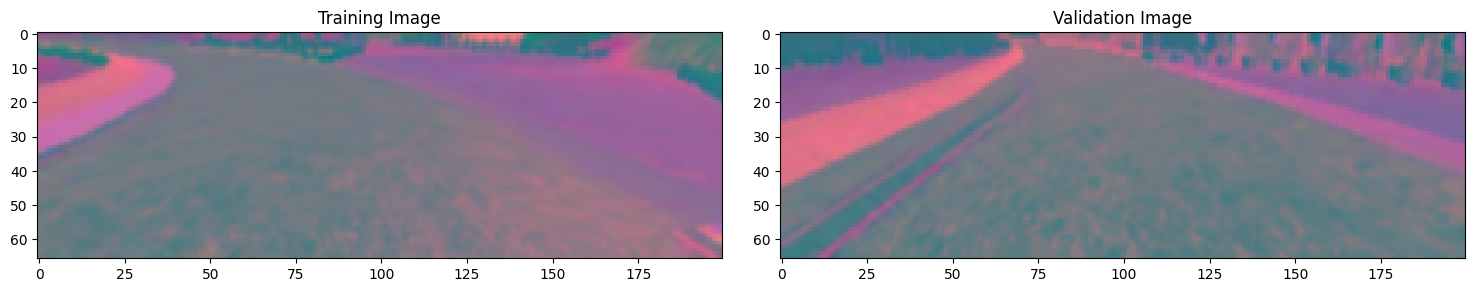

In [55]:
x_train_gen, Y_train_gen = next(batch_generator(X_train, Y_train, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


In [56]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
def model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # model.add(Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [58]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)


C:\Users\HP\AppData\Local\Temp\ipykernel_10920\1299276436.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100),


Epoch 1/10
300/300 [==============================] - 278s 920ms/step - loss: 0.1668 - val_loss: 0.0528
Epoch 2/10
300/300 [==============================] - 303s 1s/step - loss: 0.0585 - val_loss: 0.0418
Epoch 3/10
300/300 [==============================] - 456s 2s/step - loss: 0.0404 - val_loss: 0.0396
Epoch 4/10
300/300 [==============================] - 258s 858ms/step - loss: 0.0367 - val_loss: 0.0372
Epoch 5/10
300/300 [==============================] - 233s 779ms/step - loss: 0.0324 - val_loss: 0.0365
Epoch 6/10
300/300 [==============================] - 214s 715ms/step - loss: 0.0276 - val_loss: 0.0369
Epoch 7/10
300/300 [==============================] - 191s 637ms/step - loss: 0.0225 - val_loss: 0.0394
Epoch 8/10
300/300 [==============================] - 249s 832ms/step - loss: 0.0175 - val_loss: 0.0369
Epoch 9/10
300/300 [==============================] - 222s 742ms/step - loss: 0.0129 - val_loss: 0.0406
Epoch 10/10
300/300 [==============================] - 182s 608ms/step

Text(0.5, 0, 'Epoch')

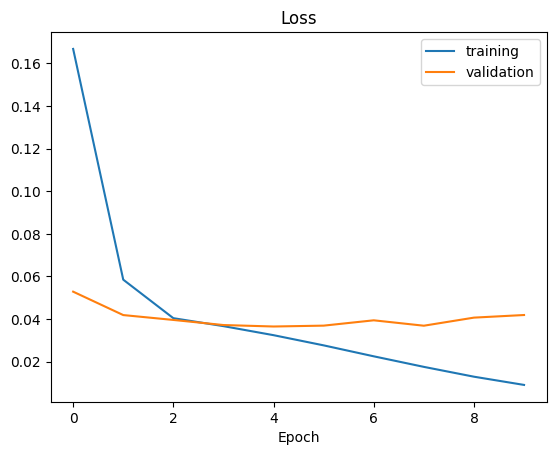

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [60]:
model.save('model2.h5')